## GradCam++

In [1]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2

In [2]:
from keras import backend as K
import tensorflow as tf

from keras.utils import load_img, img_to_array
from keras.applications.resnet import preprocess_input as resnet50_preprocess_input
from keras.models import Model, model_from_json

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

In [3]:
K.set_image_data_format('channels_last') # set the image data format to be (batch_size, height, width, channels), typically used in tensorflow

## Load model

In [4]:
# Load the model architecture and weights
with open('models/ResNet50_pretrained_2000_enhanced.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights('models/ResNet50_pretrained_2000_enhanced.weights.h5')

model.summary()

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-12-16 19:48:19.309428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-16 19:48:19.309557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [5]:
penultimate_layer = 'conv5_block3_out'

In [6]:
# Preprocess your input image
def enhance_img(img):
    # Step 1: Apply median filter with a 3x3 kernel
    img = cv2.medianBlur(img.astype(np.uint8), ksize=3)

    # Step 2: Convert to LAB color space
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_img)

    # Step 3: Apply CLAHE on the Luminosity (L) channel with 8x8 tile grid
    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Step 4: Merge CLAHE enhanced L with original A and B channels
    lab_img = cv2.merge((l, a, b))

    # Step 5: Convert back to RGB color space
    enhanced_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
    
    return enhanced_img


def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = enhance_img(img_array)
    img_array = resnet50_preprocess_input(img_array)
    return img_array

def make_df(df, num):
    # Define target sample sizes for each label
    target_sizes = {
        0: num,
        1: num,
        2: num,
        3: num,
        4: num
    }

    # Initialize a list to hold the sliced DataFrames
    sliced_dfs = []

    # Slice the DataFrame for each label
    for label, size in target_sizes.items():
        class_df = df[df['label'] == label]
        if len(class_df) >= size:
            # Undersample if the class size is greater than or equal to the target size
            sliced_df = class_df.sample(size, random_state=42)
        sliced_dfs.append(sliced_df)

    # Combine all sliced DataFrames
    final_df = pd.concat(sliced_dfs)
    
    return final_df

def load_data(df, image_dir, num):
    
    final_df = make_df(df, num)
    
    zero_df = final_df[final_df['label'] == 0]
    one_df = final_df[final_df['label'] == 1]
    two_df = final_df[final_df['label'] == 2]
    three_df = final_df[final_df['label'] == 3]
    four_df = final_df[final_df['label'] == 4]
    
    zeros, ones, twos, threes, fours = [], [], [], [], []
    path_zero, path_one, path_two, path_three, path_four = [], [], [], [], []
    

    for idx, row in tqdm(zero_df.iterrows()):
        img_name = row['image']
        img_array = preprocess_image(os.path.join(image_dir, img_name))
        zeros.append(img_array)
        path_zero.append(img_name)
        
    for idx, row in tqdm(one_df.iterrows()):
        img_name = row['image']
        img_array = preprocess_image(os.path.join(image_dir, img_name))
        ones.append(img_array)
        path_one.append(img_name)
        
    for idx, row in tqdm(two_df.iterrows()):
        img_name = row['image']
        img_array = preprocess_image(os.path.join(image_dir, img_name))
        twos.append(img_array)
        path_two.append(img_name)
        
    for idx, row in tqdm(three_df.iterrows()):
        img_name = row['image']
        img_array = preprocess_image(os.path.join(image_dir, img_name))
        threes.append(img_array)
        path_three.append(img_name)
        
    for idx, row in tqdm(four_df.iterrows()):
        img_name = row['image']
        img_array = preprocess_image(os.path.join(image_dir, img_name))
        fours.append(img_array)
        path_four.append(img_name)
        
    zeros = np.array(zeros)
    ones = np.array(ones)
    twos = np.array(twos)
    threes = np.array(threes)
    fours = np.array(fours)
    
    return zeros, ones, twos, threes, fours, path_zero, path_one, path_two, path_three, path_four

In [7]:
df = pd.read_csv(r'../../Datasets/DDR/DR_grading/labels.csv')
image_dir = r'../../Datasets/DDR/DR_grading/all'

zeros, ones, twos, threes, fours, path_zero, path_one, path_two, path_three, path_four = load_data(df, image_dir, 50)

50it [00:01, 43.65it/s]
50it [00:00, 56.28it/s]
50it [00:00, 61.85it/s]
50it [00:00, 57.75it/s]
50it [00:00, 71.97it/s]


In [8]:
# GradCam
def save_heatmap(heatmap, image_path, output_path, alpha=0.4):
    # Load original image (without preprocessing)
    original_img = load_img(image_path, target_size=(224, 224))
    original_img = img_to_array(original_img) / 255.0  # Normalize for plotting
    
    # Resize heatmap to match image size
    heatmap = np.uint8(255 * heatmap)
    
    # Clear the plot
    plt.clf()
    
    # Display the original image
    plt.imshow(original_img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)  # Overlay the heatmap with some transparency
    plt.colorbar()  # Show color bar for the heatmap
    plt.axis('off')
    
    # Save the image
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)

def generate_heatmap_image(image_path, gradcam, scores, img_array, penultimate_layer, outputs, image_name):
    heatmaps = gradcam(scores, img_array, penultimate_layer=penultimate_layer)
    for i, heatmap in enumerate(heatmaps):
        # Heatmap shape is (1, 224, 224), squeeze it to remove the batch dimension
        heatmap = np.squeeze(heatmap)
        # Save the heatmap with output index appended
        output_path = os.path.join(outputs, f"{image_name}.jpg")
        save_heatmap(heatmap, image_path, output_path)

def heatmaps(paths, samples, gradcam, scores, penultimate_layer, outputs):
    images = r'../../Datasets/DDR/DR_grading/all'
    
    for path, sample in tqdm(zip(paths, samples)):
        image_path = os.path.join(images, path)
        image_name = os.path.splitext(path)[0]  # Extract image name without extension
        generate_heatmap_image(image_path, gradcam, scores, sample, penultimate_layer, outputs, image_name)

## Gradcam

#### Level 0

50it [00:20,  2.43it/s]


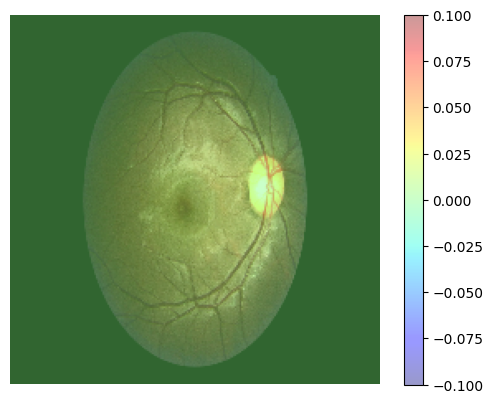

In [9]:
outputs = "GradCamEnhanced/Zero"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([0])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = Gradcam(model, clone=False)

heatmaps(path_zero, zeros, gradcam, scores, penultimate_layer, outputs)

#### Level 1

50it [00:15,  3.29it/s]


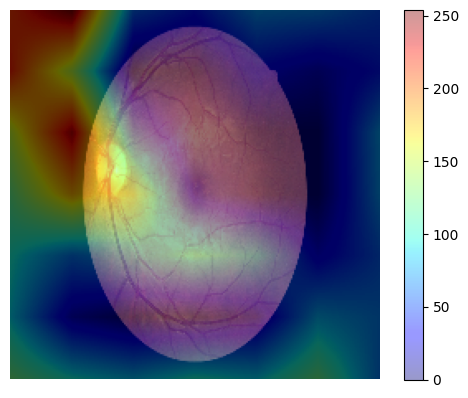

In [10]:
outputs = "GradCamEnhanced/One"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([1])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = Gradcam(model, clone=False)

heatmaps(path_one, ones, gradcam, scores, penultimate_layer, outputs)

#### Level 2

50it [00:14,  3.51it/s]


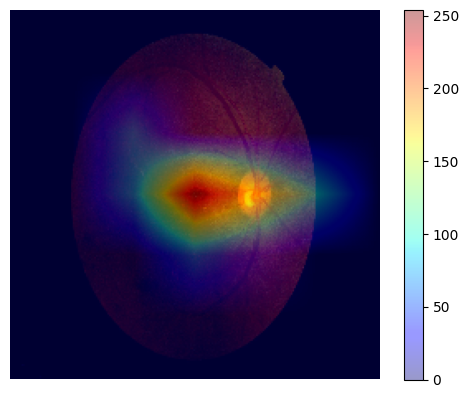

In [11]:
outputs = "GradCamEnhanced/Two"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([1])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = Gradcam(model, clone=False)

heatmaps(path_two, twos, gradcam, scores, penultimate_layer, outputs)

#### Level 3

50it [00:14,  3.42it/s]


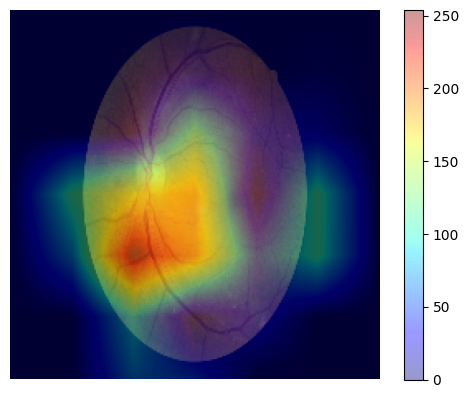

In [12]:
outputs = "GradCamEnhanced/Three"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([1])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = Gradcam(model, clone=False)

heatmaps(path_three, threes, gradcam, scores, penultimate_layer, outputs)

#### Level 4

50it [00:14,  3.49it/s]


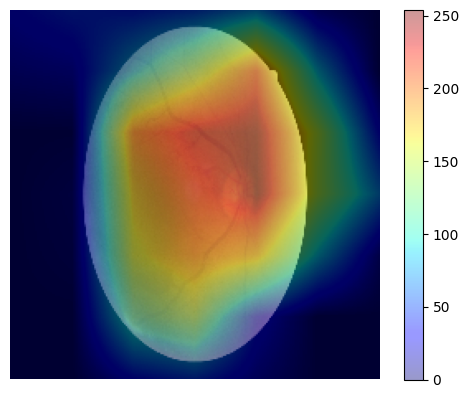

In [13]:
outputs = "GradCamEnhanced/Four"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([1])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = Gradcam(model, clone=False)

heatmaps(path_four, fours, gradcam, scores, penultimate_layer, outputs)

## Gradcam++

#### Level 0

In [ ]:
outputs = "GradCam++/Zero"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([0])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = GradcamPlusPlus(model, clone=False)

heatmaps(path_zero, zeros, gradcam, scores, penultimate_layer, outputs)

#### Level 1

In [ ]:
outputs = "GradCam++/One"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([0])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = GradcamPlusPlus(model, clone=False)

heatmaps(path_one, ones, gradcam, scores, penultimate_layer, outputs)

#### Level 2

In [ ]:
outputs = "GradCam++/Two"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([0])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = GradcamPlusPlus(model, clone=False)

heatmaps(path_two, twos, gradcam, scores, penultimate_layer, outputs)

#### Level 3

In [ ]:
outputs = "GradCam++/Three"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([0])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = GradcamPlusPlus(model, clone=False)

heatmaps(path_three, threes, gradcam, scores, penultimate_layer, outputs)

#### Level 4

In [ ]:
outputs = "GradCam++/Four"
os.makedirs(outputs, exist_ok=True)

# score = CategoricalScore([0])  # Choose class 1, you can also use CategoricalScore([0]) for class 0
score_present = CategoricalScore([0])  # Binary classification for `present_output`
score_grading = CategoricalScore([0])  # Multi-class classification for `grading_output`, class index can be changed
scores = [score_present, score_grading]

# Create the Gradcam object
gradcam = GradcamPlusPlus(model, clone=False)

heatmaps(path_four, fours, gradcam, scores, penultimate_layer, outputs)